In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Data prepairing and preprocessing

## Data Object

In [3]:
# Video Dataset Definition

class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, train=True):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.videos = []
        self.num_frames = num_frames
        self.train = train

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}


        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(('.mp4', '.avi', '.mov')):
                    self.videos.append({
                        'path': os.path.join(class_path, file),
                        'label': label
                    })

    def __len__(self):
        return len(self.videos)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def sample_frames(self, frames):
        total = len(frames)
        if total == 0:
            return None
        indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
        return [frames[i] for i in indices]

    def get_transform(self):
        """Different for train vs validation."""
        base = [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ]

        if not self.train:
            return transforms.Compose(base)

        # training augmentation (one per video)
        augmentations = [
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ColorJitter(brightness=0.3),
            transforms.ColorJitter(contrast=0.3),
            transforms.RandomRotation(degrees=10),
            None
        ]
        aug = random.choice(augmentations)
        if aug is not None:
            return transforms.Compose([aug] + base)
        return transforms.Compose(base)

    def __getitem__(self, idx):
        video_info = self.videos[idx]
        frames = self.read_video(video_info['path'])
        frames = self.sample_frames(frames)
        transform = self.get_transform()

        frames = [transform(Image.fromarray(f)) for f in frames]
        video_tensor = torch.stack(frames)  # [T, C, H, W]
        label = torch.tensor(video_info['label'])
        return video_tensor, label


## Splitting & Building the data loader

In [17]:
#  Dataset Split (Train / Val)
train_dataset = VideoDataset(root_dir="/content/drive/MyDrive/project/clean Shop Dataset/train", num_frames=16, train=True)
val_dataset = VideoDataset(root_dir="/content/drive/MyDrive/project/clean Shop Dataset/validation", num_frames=16, train=False)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Train: 420 | Val: 106


# Pretrained Model

## Model building

In [18]:
from torchvision.models.video import r2plus1d_18
model = r2plus1d_18(weights = 'KINETICS400_V1')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

## Training loop function

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
# Training Loop
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5
model.to(device)
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth"
):
    best_val_loss = float("inf")


    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for videos, labels in train_loader:
            videos = videos.permute(0, 2, 1, 3, 4)
            videos = videos.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)

            preds = (torch.sigmoid(outputs) > 0.5).long()
            running_corrects += torch.sum(preds == labels.long())
            running_loss += loss.item() * videos.size(0)

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for videos, labels in val_loader:
                videos = videos.permute(0, 2, 1, 3, 4)
                labels = labels.float().to(device)
                videos = videos.to(device)

                outputs = model(videos)
                outputs = outputs.view(-1)
                loss = criterion(outputs, labels)

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_corrects += torch.sum(preds == labels.long())
                val_loss += loss.item() * videos.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # ---- STORE RESULTS ----
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(epoch_acc.item())
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        # ---- SAVE CHECKPOINT ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Best model updated and saved at: {checkpoint_path}")

    print("\nTraining complete.")
    print(f"Lowest Val Loss: {best_val_loss:.4f}")
    return model, history


## Training

In [21]:
model, history0 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs
)


Epoch 1/5
------------------------------
Train Loss: 0.7120  Acc: 0.5571
Train Loss: 0.7120 | Acc: 0.5571
Val   Loss: 0.6812 | Acc: 0.5283
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth

Epoch 2/5
------------------------------
Train Loss: 0.6809  Acc: 0.5810
Train Loss: 0.6809 | Acc: 0.5810
Val   Loss: 1.1252 | Acc: 0.5283

Epoch 3/5
------------------------------
Train Loss: 0.6830  Acc: 0.5667
Train Loss: 0.6830 | Acc: 0.5667
Val   Loss: 0.7144 | Acc: 0.4717

Epoch 4/5
------------------------------
Train Loss: 0.6786  Acc: 0.5857
Train Loss: 0.6786 | Acc: 0.5857
Val   Loss: 0.7045 | Acc: 0.4717

Epoch 5/5
------------------------------
Train Loss: 0.6747  Acc: 0.6095
Train Loss: 0.6747 | Acc: 0.6095
Val   Loss: 0.6767 | Acc: 0.6698
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth

Training complete.
Lowest Val Loss: 0.6767


In [24]:
model, history1 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs
)


Epoch 1/5
------------------------------
Train Loss: 0.6693  Acc: 0.6167
Train Loss: 0.6693 | Acc: 0.6167
Val   Loss: 0.6135 | Acc: 0.7830
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth

Epoch 2/5
------------------------------
Train Loss: 0.6579  Acc: 0.6286
Train Loss: 0.6579 | Acc: 0.6286
Val   Loss: 0.5684 | Acc: 0.7642
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth

Epoch 3/5
------------------------------
Train Loss: 0.6661  Acc: 0.6119
Train Loss: 0.6661 | Acc: 0.6119
Val   Loss: 0.5640 | Acc: 0.8208
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model.pth

Epoch 4/5
------------------------------
Train Loss: 0.6541  Acc: 0.6000
Train Loss: 0.6541 | Acc: 0.6000
Val   Loss: 0.8131 | Acc: 0.7358

Epoch 5/5
------------------------------
Train Loss: 0.6261  Acc: 0.6714
Train Loss: 0.6261 | Acc: 0.6714
Val   Loss: 0.5750 | Acc: 0.78

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # lowering learning rate

model, history2 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model2.pth"
)


Epoch 1/5
------------------------------
Train Loss: 0.5981  Acc: 0.7048
Train Loss: 0.5981 | Acc: 0.7048
Val   Loss: 0.5019 | Acc: 0.8208
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model2.pth

Epoch 2/5
------------------------------
Train Loss: 0.5848  Acc: 0.7262
Train Loss: 0.5848 | Acc: 0.7262
Val   Loss: 0.4954 | Acc: 0.8302
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model2.pth

Epoch 3/5
------------------------------
Train Loss: 0.5811  Acc: 0.7262
Train Loss: 0.5811 | Acc: 0.7262
Val   Loss: 0.4602 | Acc: 0.8302
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model2.pth

Epoch 4/5
------------------------------
Train Loss: 0.5454  Acc: 0.7643
Train Loss: 0.5454 | Acc: 0.7643
Val   Loss: 0.4138 | Acc: 0.8396
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model2.pth

Epoch 5/5
---------------------

In [26]:
model, history3 = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    checkpoint_path="/content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth"
)


Epoch 1/5
------------------------------
Train Loss: 0.5051  Acc: 0.7738
Train Loss: 0.5051 | Acc: 0.7738
Val   Loss: 0.3435 | Acc: 0.8396
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth

Epoch 2/5
------------------------------
Train Loss: 0.5028  Acc: 0.7738
Train Loss: 0.5028 | Acc: 0.7738
Val   Loss: 0.2498 | Acc: 0.9340
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth

Epoch 3/5
------------------------------
Train Loss: 0.4544  Acc: 0.8000
Train Loss: 0.4544 | Acc: 0.8000
Val   Loss: 0.2383 | Acc: 0.9623
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth

Epoch 4/5
------------------------------
Train Loss: 0.4095  Acc: 0.8452
Train Loss: 0.4095 | Acc: 0.8452
Val   Loss: 0.2324 | Acc: 0.9434
✅ Best model updated and saved at: /content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth

Epoch 5/5
---------------------

# Evaluation

## Loading best model

In [27]:
best_model = model
best_model.load_state_dict(torch.load("/content/drive/MyDrive/project/Checkpoints/best_R(2+1)D_model3.pth"))
best_model.eval()
best_model.to(device)

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## F1_score, Precision, Recall and Accuracy

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.permute(0, 2, 1, 3, 4)
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        outputs = outputs.view(-1)
        preds = (torch.sigmoid(outputs) > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5️⃣ Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Accuracy: 0.9434
Precision: 0.9310
Recall: 0.9643
F1 Score: 0.9474


## Confusion matrix and Classification Report

In [29]:
# 1️⃣ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 2️⃣ Classification report (precision, recall, f1-score)
report = classification_report(all_labels, all_preds, target_names=["Non-Shoplifting", "Shoplifting"])
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[46  4]
 [ 2 54]]

Classification Report:
                 precision    recall  f1-score   support

Non-Shoplifting       0.96      0.92      0.94        50
    Shoplifting       0.93      0.96      0.95        56

       accuracy                           0.94       106
      macro avg       0.94      0.94      0.94       106
   weighted avg       0.94      0.94      0.94       106



## Plotting History

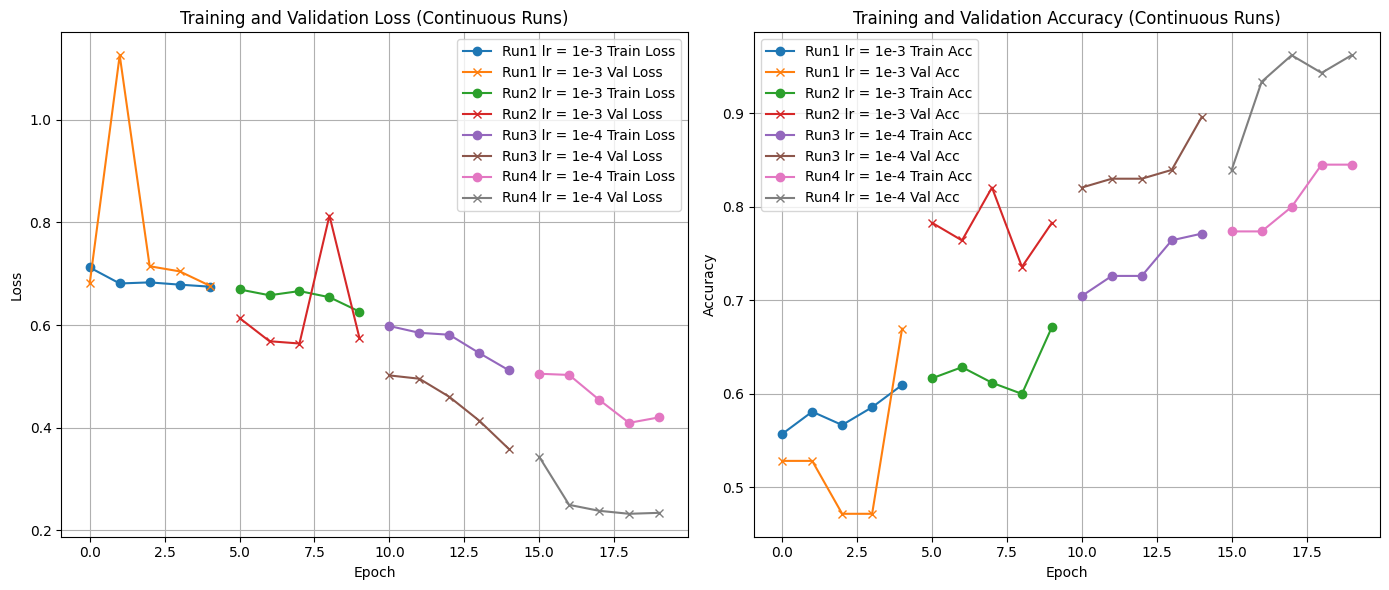

In [30]:
import matplotlib.pyplot as plt

def plot_continuous_history(histories, labels):
    plt.figure(figsize=(14, 6))
    start_epoch = 0

    # ----- Plot Loss -----
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        epochs = range(start_epoch, start_epoch + len(history["train_loss"]))
        plt.plot(epochs, history["train_loss"], marker='o', label=f"{label} Train Loss")
        plt.plot(epochs, history["val_loss"], marker='x', label=f"{label} Val Loss")
        start_epoch += len(history["train_loss"])  # shift for next run
    plt.title("Training and Validation Loss (Continuous Runs)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Reset start_epoch for accuracy plot
    start_epoch = 0

    # ----- Plot Accuracy -----
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        epochs = range(start_epoch, start_epoch + len(history["train_acc"]))
        plt.plot(epochs, history["train_acc"], marker='o', label=f"{label} Train Acc")
        plt.plot(epochs, history["val_acc"], marker='x', label=f"{label} Val Acc")
        start_epoch += len(history["train_acc"])
    plt.title("Training and Validation Accuracy (Continuous Runs)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_continuous_history(
    [history0, history1, history2, history3],
    ["Run1 lr = 1e-3", "Run2 lr = 1e-3", "Run3 lr = 1e-4", "Run4 lr = 1e-4"]
)